In [1]:
import re
import os
import csv

import pandas as pd
from os import listdir
from os.path import isfile, join
from bs4 import BeautifulSoup
from tqdm.auto import tqdm

#### The sgml tags needs to be noticed
<
REUTERS TOPICS="YES" 
LEWISSPLIT="TRAIN" 
CGISPLIT="TRAINING-SET" 
OLDID="5544" 
NEWID="1">

`LEWISSPLIT="TRAIN"` means this sgml file is `training set` in ModApte split

<
TOPICS>
<
D>
cocoa
<
/D>
<
/TOPICS>

The `text inside TOPICS tags` means `Topical category`.

<
BODY>
text text text<
/BODY>

The `text inside BODY tags` means `Text content`.

### Split warc file to docs

In [2]:
# ref : https://stackoverflow.com/questions/60269904/split-text-file-after-specific-line-in-python
def split_docs_iter(stream, start, end):
    def inner(stream):
        # Yields each line until an end marker is found (or EOF)
        for line in stream:
            if line and not end.match(line):
                yield line
                continue
            break

    # Find a start marker, then break off into a nested iterator
    for line in stream:
        if line:
            if start.match(line):
                yield inner(stream)
            continue
        break

In [5]:
REUTERS_PATH = 'reuters21578'
REUTERS_SGMLS_PATH = 'reuters_sgmls'

SECTION_START = re.compile(r'<REUTERS')
SECTION_END = re.compile(r'</REUTERS>')

CUT_START_PATTERN = "---"
CUT_END_PATTERN = "----"

CUT_START = re.compile(CUT_START_PATTERN)
CUT_END = re.compile(CUT_END_PATTERN)

files = [f for f in listdir(REUTERS_PATH) if isfile(join(REUTERS_PATH, f)) and ".sgm" in f]

# create dir
os.makedirs(REUTERS_SGMLS_PATH, exist_ok=True)

tmp_sgml = ""

# initialize the progress bar
p = tqdm(total=len(files), nrows=4, position=0, leave=True)

for file in files:
    # add patterns for later sgmls splitting
    with open(f'./{REUTERS_PATH}/{file}', 'r', encoding='ISO-8859-1') as fh_in:
        lines = fh_in.readlines()
        for line in lines:
            if SECTION_START.match(line):
                tmp_sgml += f"{CUT_START_PATTERN}\n"
                tmp_sgml += line
            elif SECTION_END.match(line):
                tmp_sgml += line
                tmp_sgml += f"{CUT_END_PATTERN}\n"
            else:
                tmp_sgml += line

    # save temporary
    with open(f'./{REUTERS_SGMLS_PATH}/tmp_sgml', 'w', encoding='UTF-8') as fh_out:
        fh_out.write(tmp_sgml)

    # split sgmls by our custom patterns
    with open(f'./{REUTERS_SGMLS_PATH}/tmp_sgml', 'r', encoding="ISO-8859-1") as fh_in:
        for (i, nested_iter) in enumerate(split_docs_iter(fh_in, CUT_START, CUT_END)):
            with open('./reuters_sgmls/docID_{:05d}'.format(i), 'w', encoding='UTF-8') as fh_out:
                for line in nested_iter:
                    fh_out.write(line)

    p.set_description('SGMLs splitted needed: ', refresh=True)
    p.update(1) # update progress bar

p.close()

os.remove(f'./{REUTERS_SGMLS_PATH}/tmp_sgml')


0it [00:00, ?it/s]


FileNotFoundError: [WinError 2] 系統找不到指定的檔案。: './reuters_sgmls/tmp_sgml'

#### Extract information from splitted sgmls

In [43]:
sgmls_files = [f for f in listdir(REUTERS_SGMLS_PATH) if isfile(join(REUTERS_SGMLS_PATH, f))]

# initialize the progress bar
pb = tqdm(total=len(sgmls_files), nrows=4, position=0, leave=True)

with open('reuter_docs.csv', "w", newline='') as csv_file:
    writer = csv.writer(csv_file)

    # header
    writer.writerow(['topics', 'body', 'train_test_label'])

    for sgml in sgmls_files:
        try:
            with open(f"{REUTERS_SGMLS_PATH}/{sgml}", 'r') as f:
                data = f.read()
                soup = BeautifulSoup(data, "html.parser")

                if not soup.find("reuters"):
                    train_test_label = "None"
                else:
                    train_test_label = soup.find("reuters")['lewissplit']

                if not soup.find("topics"):
                    topics = "None"
                else:
                    topics = soup.find("topics").get_text()

                if not soup.find("body"):
                    body = "None"
                else:
                    body = soup.find("body").get_text()

                writer.writerow([topics, body, train_test_label])

        except UnicodeDecodeError:
            print(f"{sgml} UnicodeDecodeError, pass")

        pb.set_description('Extracting SGMLs content: ', refresh=True)
        pb.update(1) # update progress bar

pb.close()

NameError: name 'REUTERS_SGMLS_PATH' is not defined

In [1]:
import re
import string

import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer  

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score, f1_score

In [2]:
df = pd.read_csv('reuter_docs.csv')

In [3]:
df.groupby('topics').size()

topics
acq                        2362
acqalum                       2
acqcopper                     3
acqcrude                      9
acqcrudenat-gas               8
                           ... 
yen                           6
zinc                         16
zinclead                      2
zincleadcopper                2
zincleadstrategic-metal       1
Length: 655, dtype: int64

In [4]:
df['topics'].unique()

array(['cocoa', nan, 'grainwheatcornbarleyoatsorghum',
       'veg-oillinseedlin-oilsoy-oilsun-oilsoybeanoilseedcornsunseedgrainsorghumwheat',
       'earn', 'acq', 'earnacq', 'wheatgrain', 'copper', 'housing',
       'money-supply', 'coffee', 'acqship', 'sugar', 'trade', 'reserves',
       'ship', 'graincorn', 'veg-oilsoybeanoilseedmeal-feedsoy-meal',
       'grainwheatcornoatryesorghumsoybeanoilseed', 'cotton', 'grainship',
       'carcasslivestock', 'grain', 'crude', 'nat-gas', 'cpignp',
       'grainwheat', 'graincornoat',
       'veg-oiloilseedmeal-feedsoybeansoy-oilsoy-meal', 'cpi',
       'money-fxinterest', 'interest', 'gnpbop', 'grainrice',
       'soybeanred-beanoilseed',
       'grainwheatriceveg-oilsoybeansugarrubbercopra-cakecornpalm-oilpalmkernelcoffeeteaplywoodsoy-mealcotton',
       'money-fx', 'meal-feedcopra-cake', 'alum', 'veg-oilpalm-oil',
       'teacocoacoffee', 'oilseedsoybean',
       'oilseedsoybeanmeal-feedsoy-meal', 'goldplatinumstrategic-metal',
       'meal

In [5]:
print(df.describe())

       topics   body train_test_label
count   11366  21577            21577
unique    655  18781                3
top      earn   None            TRAIN
freq     3945   2535            14668


In [6]:
sw = stopwords.words('english')
lemmatizer = WordNetLemmatizer() 

def clean_text(text):
    
    text = text.lower()
    
    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text) # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")

    text = re.sub(r"http\S+", "",text) #Removing URLs 
    #text = re.sub(r"http", "",text)
    
    html=re.compile(r'<.*?>') 
    
    text = html.sub(r'',text) #Removing html tags
    
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p,'') #Removing punctuations
        
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    
    text = [lemmatizer.lemmatize(word) for word in text]
    
    text = " ".join(text) #removing stopwords
    
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) #Removing emojis
    
    return text

In [7]:
df['body'] = df['body'].apply(lambda x: clean_text(x))

In [8]:
df.head()

,topics,body,train_test_label
0,cocoa,shower continued throughout week bahia cocoa z...,TRAIN
1,NaN,standard oil co bp north america inc said plan...,TRAIN
2,NaN,texas commerce bancshares inc texas commerce b...,TRAIN
3,NaN,bankamerica corp pressure act quickly proposed...,TRAIN
4,grainwheatcornbarleyoatsorghum,u agriculture department reported farmer owned...,TRAIN


In [9]:
train_set = df[(df['train_test_label']=='TRAIN')]
train_set = train_set.dropna()
train_set

,topics,body,train_test_label
0,cocoa,shower continued throughout week bahia cocoa z...,TRAIN
4,grainwheatcornbarleyoatsorghum,u agriculture department reported farmer owned...,TRAIN
5,veg-oillinseedlin-oilsoy-oilsun-oilsoybeanoils...,argentine grain board figure show crop registr...,TRAIN
8,earn,champion product inc said board director appro...,TRAIN
9,acq,computer terminal system inc said completed sa...,TRAIN
...,...,...,...
14778,dlrmoney-fx,bank japan bought small amount dollar shortly ...,TRAIN
14782,rubber,"japan rubber stock fell , tonne march , februa...",TRAIN
14784,money-fx,"bank korea said fixed midrate dollar, highest ...",TRAIN
14804,copper,nippon mining co ltd said lowered selling pric...,TRAIN


In [10]:
test_set = df[df['train_test_label']=='TEST']
test_set = test_set.dropna()
test_set

,topics,body,train_test_label
14825,trade,mounting trade friction u japan raised fear am...,TEST
14827,grain,survey province seven city showed vermin consu...,TEST
14828,crudenat-gas,ministry international trade industry miti rev...,TEST
14831,tradegrainricecornsugartinrubber,thailand trade deficit widened billion baht fi...,TEST
14832,veg-oilpalm-oil,indonesia expects crude palm oil cpo price ris...,TEST
...,...,...,...
21569,acq,chase corp ltd chcawe said make offer fully pa...,TEST
21571,money-fxdlryen,tokyo foreign exchange market watching nervous...,TEST
21572,ship,japan india pakistan gulf japan shipping confe...,TEST
21573,ipi,soviet union industrial output growing slower ...,TEST


In [11]:
tfidf_vectorizer = TfidfVectorizer() 

tfidf_train_vectors = tfidf_vectorizer.fit_transform(train_set['body'])

tfidf_test_vectors = tfidf_vectorizer.transform(test_set['body'])

NB

In [31]:
%%time
model = MultinomialNB().fit(tfidf_train_vectors, train_set['topics'])

pred_topics = model.predict(tfidf_test_vectors)

print('Accuracy:', accuracy_score(test_set['topics'], pred_topics))
print('Weighted F1 score:', f1_score(test_set['topics'], pred_topics, average='weighted'))

Accuracy: 0.5746441575637207
Weighted F1 score: 0.4511153980593111
CPU times: total: 531 ms
Wall time: 527 ms


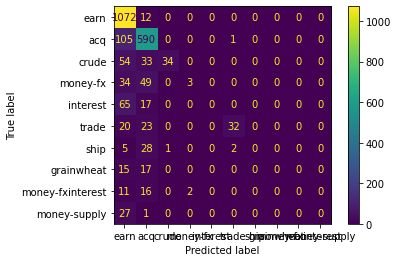

In [20]:
y_true = test_set['topics']
y_pred = pred_topics

labels = test_set['topics'].value_counts()[:10].index

# top 10 results
cm = confusion_matrix(y_true, y_pred, labels=labels)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels).plot()
plt.show()

Find best KNN n_neighbors

In [27]:
from sklearn.neighbors import KNeighborsClassifier

In [46]:
k = 3
biggest_accuracy_score = 0

for i in range(3,25,2):

    knn = KNeighborsClassifier(n_neighbors=i)

    # training our classifier ; train_data.target will be having numbers assigned for each category in train data
    clf = knn.fit(tfidf_train_vectors,train_set['topics'])
    predicted_by_knn = clf.predict(tfidf_test_vectors)
    score = accuracy_score(test_set['topics'], predicted_by_knn)
    if score > biggest_accuracy_score:
        biggest_accuracy_score =score
        k = i
print('Accuracy:', biggest_accuracy_score)
print('K:',k)

d:\anaconda\lib\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
d:\anaconda\lib\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avo

Accuracy: 0.7014233697451175
K: 13


d:\anaconda\lib\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [30]:
%%time
knn = KNeighborsClassifier(n_neighbors=13)

# training our classifier ; train_data.target will be having numbers assigned for each category in train data
clf = knn.fit(tfidf_train_vectors, train_set['topics'])
predicted_by_knn = clf.predict(tfidf_test_vectors)

print(accuracy_score(test_set['topics'], predicted_by_knn))
print(f1_score(test_set['topics'], predicted_by_knn, average='weighted'))

0.7014233697451175
0.6600828875152751
CPU times: total: 828 ms
Wall time: 829 ms


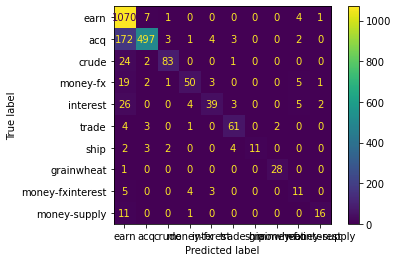

In [32]:
y_true = test_set['topics']
y_pred = predicted_by_knn

labels = test_set['topics'].value_counts()[:10].index

# top 10 results
cm = confusion_matrix(y_true, y_pred, labels=labels)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels).plot()
plt.show()